In [1]:
import sys
import os
import glob
import struct
import binascii
import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# import dateutil
# from scipy import __version__ as scipy_version
# import scipy.interpolate
# import scipy.stats
# from statsmodels import __version__ as statsmodels_version
# import statsmodels.formula.api as smformula

from collections import OrderedDict
from IPython.display import display, HTML

print(sys.version)
print('numpy', np.__version__)
print('matplotlib', mpl.__version__)
print('pandas',pd.__version__)
# print('scipy', scipy_version)
# print('statsmodels', statsmodels_version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
numpy 1.13.3
matplotlib 2.2.2
pandas 0.20.3


In [2]:
# Setup plot style
%matplotlib notebook
plt.style.use('seaborn-paper')
mpl.rcParams['figure.facecolor'] = (0.8, 0.8, 0.8, 1)

In [3]:
# Misc utility functions
def tempF2C(x): return (x-32.0)*5.0/9.0
def tempC2F(x): return (x*9.0/5.0)+32.0

In [4]:
def msbin2ieee(msbin):
    """
    Convert an array of 4 bytes containing Microsoft Binary floating point
    number to IEEE floating point format (which is used by Python)
    adapted from: https://github.com/choonkeat/ms2txt/blob/master/metastock/utils.py
    """
    as_int = struct.unpack("i", msbin)
    if not as_int:
        return 0.0
    man = int(struct.unpack('H', msbin[2:])[0])
    if not man:
        return 0.0
    exp = (man & 0xff00) - 0x0200
    man = man & 0x7f | (man << 8) & 0x8000
    man |= exp >> 1
    ieee = msbin[:2]
    ieee += bytes([man & 0xFF])
    ieee += bytes([(man >> 8) & 0xFF])
#     print(ieee)
    return struct.unpack("f", ieee)[0]

display(msbin2ieee(b'\xDB\x0F\x49\x81')*2) # should ~= pi
display(msbin2ieee(b'\xCD\xCC\x70\x86'))

3.1415927410125732

60.20000076293945

In [5]:
FN = '../../cdfa_dd/LAAR17'
INPUT_TEMPS_IN_F = True # output should be C

In [6]:
# 3 AS N$, 2 AS D$, 2 AS M$, 2 AS Y$, 5 AS M2$, 5 AS M3$, 16 AS X$
date_fmt = r"=hchhh" # 5 5 16"
date_size = struct.calcsize(date_fmt)
current_year = int(datetime.datetime.strftime(datetime.date.today(), '%Y'))

dat = []
with open(FN,'rb') as fh:
    while True:
        date_bytes = fh.read(date_size)
        if len(date_bytes) < date_size:
            if len(date_bytes) > 0:
                print("WARNING: Some data left in file")
            break
        (n, _, d, m, y) = struct.unpack(date_fmt, date_bytes)
        tmin = msbin2ieee(fh.read(4))
        assert fh.read(1) == b' ' # This byte should be a space (0x20)
        tmax = msbin2ieee(fh.read(4))
        assert fh.read(1) == b' ' # This byte should be a space (0x20)
        fooX = fh.read(16) # specified in old BASIC code but not used.  Don't know what it is
        # mark projections more properly
        is_projection = y==0
        # F to C if needed
        if False: #INPUT_TEMPS_IN_F:
            tmin = tempF2C(tmin)
            tmax = tempF2C(tmax)
        # convert 2 digit date to 4 digits... This will break in 2100
        fully = y+2000
        if fully > current_year:
            fully -= 100
        if is_projection:
            fully = current_year
        date_str = "{:04d}-{:02d}-{:02d}".format(fully, m, d)
        dat.append([n, d, m, y, tmin, tmax, date_str, is_projection])
        _ = fh.read(128-35) # skip to next record in the file (each record is 128 bytes because??)
    dat = pd.DataFrame(dat, columns=['jday', 'day', 'month', 'year', 'Tmin', 'Tmax', 'date_str', 'is_projection'])

# make date col of datetime objects
dat['date'] = pd.to_datetime(dat['date_str'])
dat.drop('date_str', axis=1, inplace=True) # don't need the strings anymore

display(dat)

,jday,day,month,year,Tmin,Tmax,is_projection,date
0,1,1,1,17,42.700001,60.200001,False,2017-01-01
1,2,2,1,17,52.000000,58.299999,False,2017-01-02
2,3,3,1,17,49.099998,59.599998,False,2017-01-03
3,4,4,1,17,48.200001,61.900002,False,2017-01-04
4,5,5,1,17,49.299999,58.099998,False,2017-01-05
5,6,6,1,17,47.400002,56.700001,False,2017-01-06
6,7,7,1,17,46.299999,58.000000,False,2017-01-07
7,8,8,1,17,45.000000,63.299999,False,2017-01-08
8,9,9,1,17,46.299999,60.700001,False,2017-01-09
9,10,10,1,17,52.200001,63.000000,False,2017-01-10


In [7]:
t = dat.copy(deep=True)
t = t.set_index('date')
t.loc['2017-01-04':'2017-01-07'] = np.nan
t.head(10)

,jday,day,month,year,Tmin,Tmax,is_projection
date,,,,,,,
2017-01-01,1.0,1.0,1.0,17.0,42.700001,60.200001,0.0
2017-01-02,2.0,2.0,1.0,17.0,52.000000,58.299999,0.0
2017-01-03,3.0,3.0,1.0,17.0,49.099998,59.599998,0.0
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08,8.0,8.0,1.0,17.0,45.000000,63.299999,0.0
2017-01-09,9.0,9.0,1.0,17.0,46.299999,60.700001,0.0


## DD plot

In [112]:
### Plotting
t = pd.read_hdf('../t.hdf','table')
dd = pd.read_hdf('../dd.hdf','table')

array([Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-28 00:00:00'),
       Timestamp('2018-05-28 00:00:00'), Timestamp('2018-07-05 00:00:00')],
      dtype=object)

<IPython.core.display.Javascript object>


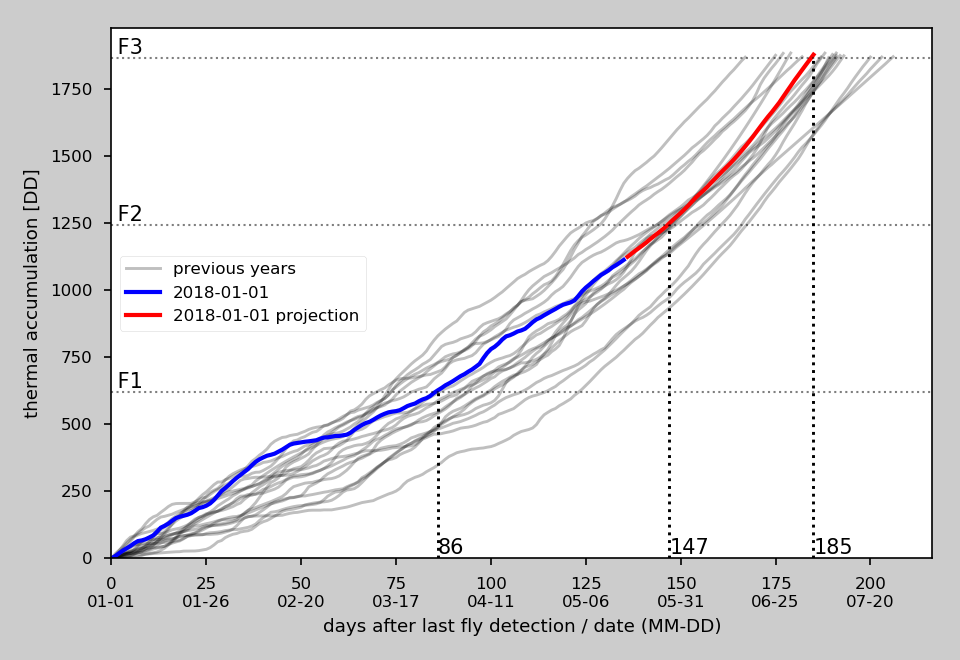

No data for year 2000; skipping


In [141]:
start_date = '2018-01-01'
DD_per_gen = 622
num_gen = 3

cDD = dd['DD'].cumsum(skipna=False)
start_dt = pd.to_datetime(start_date)
proj_start_dt = t[t['normN'] > 0].index[0] # first day of projection based on normals

# compute generation dates
startcDD = cDD.loc[start_date]
fdate = np.empty([num_gen+1], dtype=type(start_dt))
fdate[0] = start_dt
tmp = cDD-startcDD
for gen in range(1,num_gen+1):
    fdate[gen] = cDD[tmp>DD_per_gen*gen].index[0]
display(fdate)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# previous years
lab = 'previous years'
for yr in np.arange(dd.index[0].year, start_dt.year):
    sd = start_dt.replace(year=yr)
    if not sd in dd.index:
        print("No data for year {}; skipping".format(yr))
        continue
    tmp = cDD-cDD.loc[sd]
    tmp = tmp.loc[sd:tmp[tmp>DD_per_gen*num_gen].index[0]]
    ax.plot((tmp.index-sd).days, tmp, '-', c='k', alpha=0.25, label=lab, zorder=1)
    lab = '' # only label first line

# from the given start_date
tmp = (cDD-startcDD).loc[fdate[0]:fdate[-1]]
proj_mask = tmp.index >= proj_start_dt
ax.plot((tmp[~proj_mask].index-start_dt).days, tmp[~proj_mask],
        '-', c='b', lw=2, label=str(start_dt.date()))
ax.plot((tmp[proj_mask].index-start_dt).days, tmp[proj_mask],
        '-', c='r', lw=2, label=str(start_dt.date())+" projection")
    
trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
trans2 = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
for i in range(num_gen):
    y = DD_per_gen*(i+1)
    ax.axhline(y=y, c='k', ls=':', alpha=0.5, lw=1)
    ax.text(0, y, ' F{:d}'.format(i+1), transform=trans, ha='left', va='bottom')
    x = (fdate[i+1]-fdate[0]).days
    ax.stem([x], [y], linefmt='k:', markerfmt='none')
    ax.text(x, 0, '{:d}'.format(int(x)), transform=trans2, ha='left', va='bottom')
    
# xlabel in days and MM-DD dates
def foo_formatter(x, pos):
    tmp = start_dt+pd.Timedelta(days=x)
    return "{:d}\n{:02d}-{:02d}".format(int(x), tmp.month, tmp.day)
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(foo_formatter))

ax.set_xlabel('days after last fly detection / date (MM-DD)')
ax.set_ylabel('thermal accumulation [DD]')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()
fig.tight_layout()

In [121]:
t[t['normN'] > 0].index[0]

Timestamp('2018-05-17 00:00:00')

## Temperatures plot

In [5]:
### Plotting
t = pd.read_hdf('../t.hdf','table')
dd = pd.read_hdf('../dd.hdf','table')

In [6]:
t.head()

,cntAT,minAT,maxAT,filled,normN
2000-11-28,5.0,55.97,82.95,0.0,0
2000-11-29,6.0,51.79,64.22,0.0,0
2000-11-30,6.0,48.25,66.96,0.0,0
2000-12-01,6.0,49.67,61.48,0.0,0
2000-12-02,6.0,51.79,66.96,0.0,0


<IPython.core.display.Javascript object>


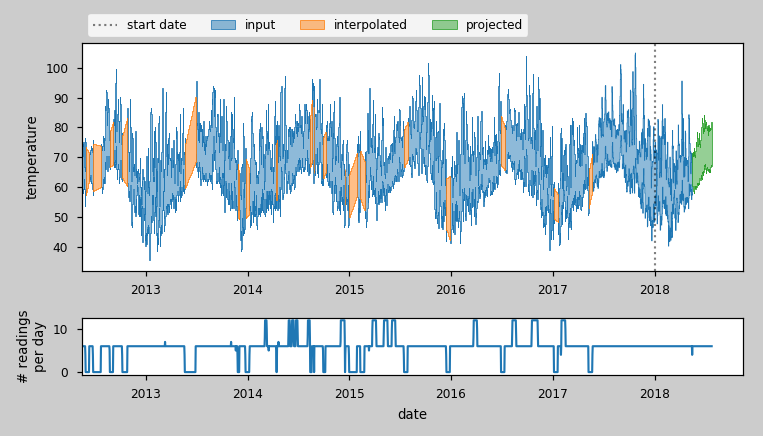

In [70]:
norm_start = pd.to_datetime('2012-05-17')
max_plot_date = pd.to_datetime('2018-07-25')
start_date = '2018-01-01'
min_readings_per_day = 4

t2 = t.loc[norm_start:max_plot_date] # only show values actually used

fig = plt.figure(figsize=(7,4))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4,1])

ax = fig.add_subplot(gs[0,0])

regions = [['input',        (t2['filled'] == 0) & (t2['normN'] == 0), 'C0'],
           ['interpolated', (t2['filled'] != 0) & (t2['normN'] == 0), 'C1'],
           ['projected',    (t2['normN'] != 0),                       'C2'],
          ]
for label, mask, color in regions:
    tmp = t2.copy()
    tmp.loc[~mask] = np.nan
    x = np.column_stack((tmp.index, tmp.index+pd.Timedelta(days=1))).flatten()
    ymin = np.column_stack((tmp['minAT'], tmp['minAT'])).flatten()
    ymax = np.column_stack((tmp['maxAT'], tmp['maxAT'])).flatten()
    ax.fill_between(x, ymin, ymax, linewidth=0.5,
                    facecolor=mpl.colors.to_rgba(color, alpha=0.5),
                    edgecolor=mpl.colors.to_rgba(color, alpha=1),
                    label=label)

ax.axvline(x=pd.to_datetime(start_date), c='k', ls=':', label="start date", alpha=0.5)
ldg = ax.legend(loc='lower left', ncol=4, bbox_to_anchor=(0,1))
ax.set_ylabel("temperature")

ax2 = fig.add_subplot(gs[1,0], sharex=ax)
# ax2.axhline(y=min_readings_per_day, c='k', lw=.5)
ax2.plot(t2.index, t2['cntAT'])
ax2.set_ylabel("# readings\nper day")
ax2.set_xlabel("date")
ax2.set_xlim(left=t2.index[0])
fig.tight_layout()    